# Contrôle de TP M2 IARF-Rodeco

**Auteurs :** Benjamin Chamand - Thomas Pellegrini

Le but de cette séance est d'évaluer vos compétences sur un projet d'apprentissage profond en utilisant un nouveau corpus.

Contrairement aux séances précédentes, nous allons travailler cette fois-ci sur un corpus audio contenant 10 classes (craquemens de feu, tic-tac d'une horloge, le bruit d'un coq, etc...).

Les fichiers audio sont convertis en spectrogramme, une représentation temps/fréquence du signal qui peut être vue comme une image.

**La méthodologie reste la même et ne change absolument pas par rapport aux séances précédentes ! Toutes les méthodes vues durant les séances précédentes peuvent donc être réapliquées ici.**

## Gestion des pré-requis avant de commencer le contrôle

__Afin de ne pas perdre du temps sur les exécutions de chaque cellule du notebook, vous pouvez tout exécuter en allant dans le menu *Exécution* puis *Tout exécuter*__

### Importation des bibliothèques

Premièrement, faisons les importations nécessaires

In [1]:
import os
import random
import requests
import zipfile

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import numpy as np
import matplotlib.pyplot as plt

Installation de la bibliothèque **librosa** qui va se charger d'ouvrir les fichiers audio et d'en extraire le spectrogramme qui sera traité ensuite comme une image dans la suite.

In [2]:
!pip install librosa
import librosa
import librosa.display

Vérifier bien que Keras utilise le GPU pour les calculs.
Si ce n'est pas le cas, il faut aller dans Exéction > Modifier le type d'exécution > Accélérateur Matériel > GPU

In [3]:
if K.backend() == "tensorflow":
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7054431230320485151
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9949325578419902282
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1388526401329989524
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7298761376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5776589237307874827
physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"
]


### Fixer la seed

On fixe la seed afin de retrouver les mêmes résultats à chaque lancement du programme.

In [4]:
from numpy.random import seed
seed(123) # On peut utiliser n'importe quelle nombre

import tensorflow
tensorflow.random.set_seed(1234)

### Chargement du corpus

Le corpus est constitué de 10 concepts audio qui sont :
* **tronçonneuse** *(chainsaw)*
* **tic-tac d'une horloge** *(clock_tick)*
* **craquement de feu** *(crackling_fire)*
* **pleurs de bébé** *(crying_baby)*
* **chien** *(dog)*
* **hélicoptère** *(helicopter)*
* **pluie** *(rain)*
* **coq** *(rooster)*
* **bruit des vagues** *(sea_waves)*
* **éternuement** *(sneezing)*

Nous voulons classifier les différents fichiers audio suivant les 10 classes.

#### Téléchargement du corpus

On récupère tout d'abord le corpus

In [5]:
!wget -O dataset.zip https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
!unzip -qq dataset.zip -d data/
!rm dataset.zip

--2020-10-22 14:23:39--  https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
Resolving www.irit.fr (www.irit.fr)... 141.115.28.2
Connecting to www.irit.fr (www.irit.fr)|141.115.28.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128685900 (123M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 122.72M  8.10MB/s    in 17s     

2020-10-22 14:23:57 (7.35 MB/s) - ‘dataset.zip’ saved [128685900/128685900]



La base de données téléchargée est stockée dans :

```
./data
```
Vous pouvez visualiser l'arborescence des données dans la colonne de gauche sous l'onglet *Fichiers* et en cliquant sur le bouton *actualiser* si les données n'apparaissent pas.

In [6]:
base_dir = './data'

#### Chargement du corpus dans la mémoire

La fonction **load_dataset** permet de charger les données d'apprentissage ou les données de test en mémoire.

**Attention :** le chargement est un peu long (environ 2min)

In [7]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']


def load_dataset(path):
    spec = []
    labels = []
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                if (not entry.name.startswith('.')
                        and entry.name.endswith('.wav')):
                    # load audio
                    y, sr = librosa.load(entry.path)
                    # convert audio to melspectrogram
                    spec.append(librosa.feature.melspectrogram(y, sr,
                                                              n_fft=2048,
                                                              hop_length=512,
                                                              power=2.0))
                    # add associated label
                    labels.append(idx)

    # mélange les données 
    #combined = list(zip(spec, labels))
    #random.shuffle(combined)
    #spec, labels = zip(*combined)
    return np.array(spec), np.array(labels)

In [8]:
# Le chargement des données est assez long : un peu moins de 2min
%%time

print("Chargement du corpus d'apprentissage")
train_dir = os.path.join(base_dir, 'train')
x_train, y_train = load_dataset(train_dir)

print("Chargement du corpus de test")
test_dir = os.path.join(base_dir, 'test')
x_test, y_test = load_dataset(test_dir)

Chargement du corpus d'apprentissage
Chargement du corpus de test
CPU times: user 1min 21s, sys: 12.5 s, total: 1min 33s
Wall time: 2min 12s


#### Taille du corpus

Affichage de la taille du corpus. Pour cela, il suffit de compter le nombre d'images qu'il y a dans les dossiers correspondant à chaque label aussi bien dans le corpus d'apprentissage que dans le corpus de test.

In [9]:
# Affichage du nombre d'exemples totales dans le corpus
print('Taille du corpus total')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus 
print('\nTaille des données d\'apprentissage')
print('\t• X_train (images) :', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTaille des données de test')
print('\t• X_test (images) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

Taille du corpus total
	• train : 320 exemples
	• test : 80 exemples

Taille des données d'apprentissage
	• X_train (images) : (320, 128, 216)
	• y_train (labels) : (320,)

Taille des données de test
	• X_test (images) : (80, 128, 216)
	• y_test (labels) : (80,)


**Correspondance ID du label / signification**

Définition de la liste *idx_to_classes* permettant à partir de la valeur du label de retrouver sa signification

In [10]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']

# du corpus d'apprentissage
print("Affichage de la correspondance des labels :")
for i in range(10):
    n = random.randint(0, len(y_train)-1)
    print('• y_train[' + str(n) + '] =', y_train[n], '->', idx_to_classes[y_train[n]])

Affichage de la correspondance des labels :
• y_train[82] = 2 -> crackling_fire
• y_train[116] = 3 -> crying_baby
• y_train[14] = 0 -> chainsaw
• y_train[69] = 2 -> crackling_fire
• y_train[242] = 7 -> rooster
• y_train[134] = 4 -> dog
• y_train[106] = 3 -> crying_baby
• y_train[234] = 7 -> rooster
• y_train[170] = 5 -> helicopter
• y_train[258] = 8 -> sea_waves


**Affichage des images**

On affiche maintenant quelques images issues du corpus avec le label associé

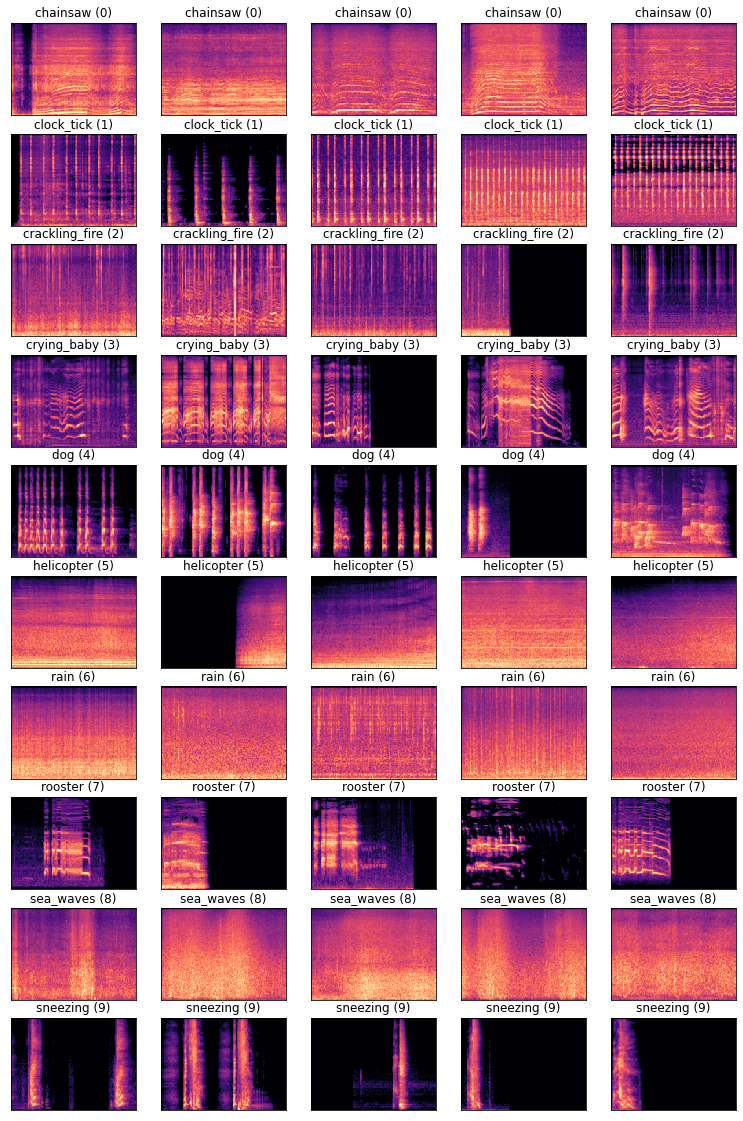

In [11]:
plt.figure(figsize=(13,20))

n = 0
for i in range(10):
    for j in range(5):
        # récupération d'une image et de son label associé
        img, target = x_train[n+j], y_train[n+j]
        # affiche du spectrogramme
        plt.subplot(10,5,i*5+j+1)
        img = librosa.power_to_db(img)
        librosa.display.specshow(img, cmap='magma')
        # ajout d'un titre à l'image
        plt.title('{} ({})'.format(idx_to_classes[target], target))
        #plt.colorbar(format='%+2.0f dB')
    n += 32
              
plt.show()

## Classification de fichiers audio en utilisant de l'apprentissage profond

Maintenant c'est à vous de jouer, vous devez implémenter différentes architectures de réseaux de neurones à partir de vos connaissances et des modèles que vous avez vus dans les séances précédentes.

Pour cela, vous devriez :

* faire attention au format des données en entrée (reshape des images, transformer un vecteur en one-hot encoding, etc.) ;
* déclarer l'architecture ;
* compiler le modèle ;
* lancer l'apprentissage ;
* évaluer le modèle ;
* lancer la prédiction sur quelques images de tests.

Pour l'évalutation du modèle, nous utiliserons nos données de tests ce qui n'est normalement pas rigoureux.

### Réseau MLP

Dans cette section, vous allez devoir implémenter un réseau dense à 1 ou plusieurs couches cachées

In [12]:
# Conversion des données en type float32:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [13]:
nb_classes = 10

# one-hot encoding
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


In [14]:
def img_reshape(X_train, X_test):
    X_train = X_train.reshape((-1,128*216))
    X_test = X_test.reshape((-1,128*216))
    return X_train, X_test

In [15]:
# définition du rééchelonnage
def reechelonnage(X_train, X_test):
    X_train = X_train/255
    X_test = X_test/255
    return X_train, X_test

In [16]:
# définition de la standardisation
def standardisation(X_train, X_test):
    X_train = (X_train-np.mean(X_train))/np.std(X_train) 
    X_test = (X_test-np.mean(X_train))/np.std(X_train)
    return X_train, X_test

In [17]:
X_train, X_test = x_train, x_test
X_train, X_test = reechelonnage(X_train, X_test)
X_train, X_test = standardisation(X_train, X_test)
X_train, X_test = img_reshape(X_train, X_test)

print('\nTaille des données :')
print('\t• X_train :', X_train.shape)
print('\t• X_test :', X_test.shape)


Taille des données :
	• X_train : (320, 27648)
	• X_test : (80, 27648)


In [18]:
# Model initialization:
model = Sequential()


#input 128*216
model.add(keras.Input(shape=(27648,)))


model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(32, activation="relu"))
#model.add(keras.layers.Dense(25, activation="relu"))

# Couche de sortie 10 neurones pour les 10 classes possibles
# On fixe la fonction d'activation a softmax car il y a 10 classes possibles en sortie
model.add(keras.layers.Dense(10, activation="softmax"))

#On precise ici la fonction de cout 
#On choisira la CategoricalCrossentropy car nous avons plus de 2 classes possibles en sortie
model.compile(loss=keras.losses.CategoricalCrossentropy(), 
              #optimizer='rmsprop',
              #optimizer='sgd',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
#résumé de mon réseau
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                829470    
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
Total params: 830,710
Trainable params: 830,710
Non-trainable params: 0
_________________________________________________________________


In [20]:
%%time
epochs = 10

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=32)

Epoch 1/10
10/10 [==============================] - 0s 4ms/step - loss: 3.0298 - accuracy: 0.1781
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 1.8445 - accuracy: 0.3844
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 1.4105 - accuracy: 0.5281
Epoch 4/10
10/10 [==============================] - 0s 4ms/step - loss: 1.2618 - accuracy: 0.6094
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 1.1831 - accuracy: 0.6500
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.8351 - accuracy: 0.7281
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 0.7389 - accuracy: 0.7750
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 0.6197 - accuracy: 0.8156
Epoch 9/10
10/10 [==============================] - 0s 3ms/step - loss: 0.5196 - accuracy: 0.8438
Epoch 10/10
10/10 [==============================] - 0s 4ms/step - loss: 0.5487 - accuracy: 0.8375
CPU times: user 1.0

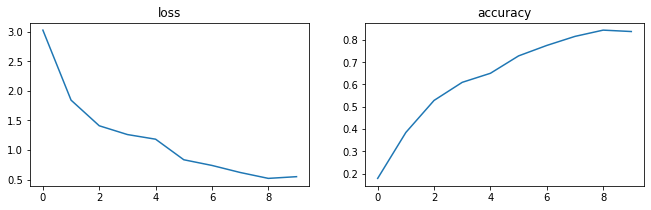

In [21]:
plt.figure(figsize=(11,3))

# affichage de la valeur de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

# affichage de la précision de notre réseau sur les données d'apprentissage
plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

In [22]:
%%time
scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3/3 - 0s - loss: 2.0065 - accuracy: 0.2750
accuracy: 27.50%
CPU times: user 154 ms, sys: 3.25 ms, total: 157 ms
Wall time: 154 ms


In [23]:
predictions = model.predict(X_test)

In [24]:
# afficage de la matrice de confusions
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
acc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i,j in enumerate(acc.diagonal()):
    print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

[[5 0 0 0 0 2 1 0 0 0]
 [0 1 0 0 0 2 0 0 0 5]
 [0 0 0 0 0 2 1 0 0 5]
 [1 0 3 1 0 0 1 1 1 0]
 [2 0 0 0 2 0 0 0 4 0]
 [0 0 0 0 0 6 0 0 2 0]
 [2 1 3 0 0 1 0 0 1 0]
 [1 0 0 1 0 0 0 4 0 2]
 [6 0 0 0 0 2 0 0 0 0]
 [0 0 1 3 0 1 0 0 0 3]]

Classification accuracy for each class:

0: 0.6250
1: 0.1250
2: 0.0000
3: 0.1250
4: 0.2500
5: 0.7500
6: 0.0000
7: 0.5000
8: 0.0000
9: 0.3750


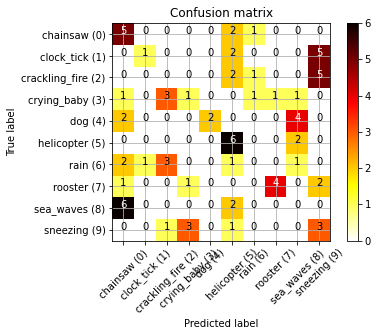

In [25]:
# afficage de la matrice de confusions dans un autre format
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.hot_r)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(idx_to_classes))
plt.grid(None)
classes_name = zip(idx_to_classes, list(range(len(idx_to_classes))))
classes_name = ['{} ({})'.format(*i) for i in classes_name]
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Réseau convolutif

Maintenant, vous allez implémenter un réseau convolutif.

In [34]:
# définition des tailles des images
im_width, im_height = 216, 128
n_channels = 3
num_classes = 10
num_epochs = 10
batch_size = 32

In [35]:
input_train = x_train
input_test = x_test
input_train = input_train.reshape(list(input_train.shape) + [1]) 
input_test = input_test.reshape(list(input_test.shape) + [1])

In [36]:
target_train = y_train
target_test = y_test
target_train = keras.utils.to_categorical(target_train)
target_test = keras.utils.to_categorical(target_test)

In [37]:
# défintion du modèle
model = Sequential()

# Features extraction
model.add(Conv2D(16, 3, input_shape=(im_height, im_width, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(32, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(2))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer='nadam', loss='categorical_crossentropy',  metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 214, 16)      160       
_________________________________________________________________
activation_3 (Activation)    (None, 126, 214, 16)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 107, 16)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 105, 32)       4640      
_________________________________________________________________
activation_4 (Activation)    (None, 61, 105, 32)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 52, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 50, 64)       

In [39]:
#compile model using accuracy to measure model performance
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
#train the model
history = model.fit(input_train, target_train, epochs=num_epochs, batch_size=batch_size)

Epoch 1/10
10/10 [==============================] - 0s 22ms/step - loss: 10.7497 - accuracy: 0.2562
Epoch 2/10
10/10 [==============================] - 0s 21ms/step - loss: 1.3276 - accuracy: 0.6625
Epoch 3/10
10/10 [==============================] - 0s 20ms/step - loss: 0.6577 - accuracy: 0.8344
Epoch 4/10
10/10 [==============================] - 0s 21ms/step - loss: 0.4160 - accuracy: 0.9000
Epoch 5/10
10/10 [==============================] - 0s 20ms/step - loss: 0.3019 - accuracy: 0.9094
Epoch 6/10
10/10 [==============================] - 0s 20ms/step - loss: 0.2314 - accuracy: 0.9312
Epoch 7/10
10/10 [==============================] - 0s 21ms/step - loss: 0.1838 - accuracy: 0.9563
Epoch 8/10
10/10 [==============================] - 0s 20ms/step - loss: 0.1508 - accuracy: 0.9625
Epoch 9/10
10/10 [==============================] - 0s 20ms/step - loss: 0.1294 - accuracy: 0.9594
Epoch 10/10
10/10 [==============================] - 0s 20ms/step - loss: 0.1154 - accuracy: 0.9625


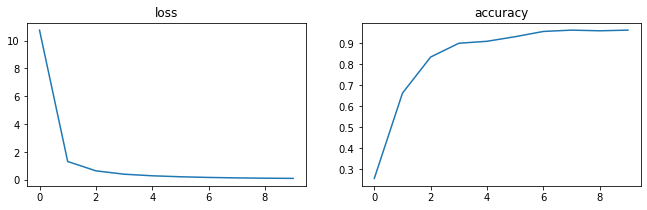

In [41]:
plt.figure(figsize=(11,3))

# affichage de la valeur de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

# affichage de la précision de notre réseau sur les données d'apprentissage
plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

Confusion matrix (rows: true classes; columns: predicted classes):



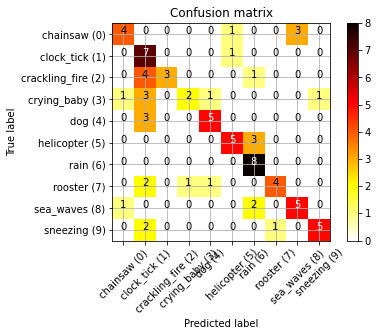

In [43]:
predictions = model.predict(input_test)
# afficage de la matrice de confusions
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(10)))
# afficage de la matrice de confusions dans un autre format
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.hot_r)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(idx_to_classes))
plt.grid(None)
classes_name = zip(idx_to_classes, list(range(len(idx_to_classes))))
classes_name = ['{} ({})'.format(*i) for i in classes_name]
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [44]:
scores = model.evaluate(input_test, target_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3/3 - 0s - loss: 2.1545 - accuracy: 0.6000
accuracy: 60.00%


In [45]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [46]:
datagen.fit(input_train)

In [47]:
#compile model using accuracy to measure model performance
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
history = model.fit(datagen.flow(input_train, target_train, batch_size=batch_size), epochs=num_epochs)

Epoch 1/10
10/10 [==============================] - 1s 60ms/step - loss: 2.6112 - accuracy: 0.1656
Epoch 2/10
10/10 [==============================] - 1s 62ms/step - loss: 2.1259 - accuracy: 0.2156
Epoch 3/10
10/10 [==============================] - 1s 60ms/step - loss: 1.9219 - accuracy: 0.3219
Epoch 4/10
10/10 [==============================] - 1s 61ms/step - loss: 1.8537 - accuracy: 0.3156
Epoch 5/10
10/10 [==============================] - 1s 60ms/step - loss: 1.8161 - accuracy: 0.3688
Epoch 6/10
10/10 [==============================] - 1s 61ms/step - loss: 1.6537 - accuracy: 0.4156
Epoch 7/10
10/10 [==============================] - 1s 62ms/step - loss: 1.6674 - accuracy: 0.4156
Epoch 8/10
10/10 [==============================] - 1s 62ms/step - loss: 1.5945 - accuracy: 0.4500
Epoch 9/10
10/10 [==============================] - 1s 63ms/step - loss: 1.6011 - accuracy: 0.4125
Epoch 10/10
10/10 [==============================] - 1s 62ms/step - loss: 1.4499 - accuracy: 0.4750


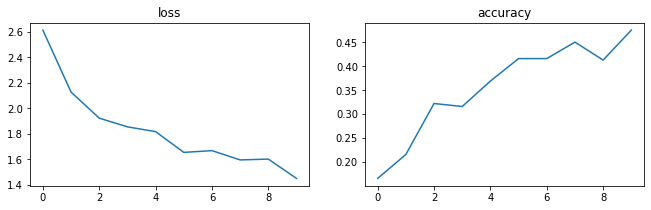

In [49]:
plt.figure(figsize=(11,3))

# affichage de la valeur de la fonction de perte
plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

# affichage de la précision de notre réseau sur les données d'apprentissage
plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

Confusion matrix (rows: true classes; columns: predicted classes):



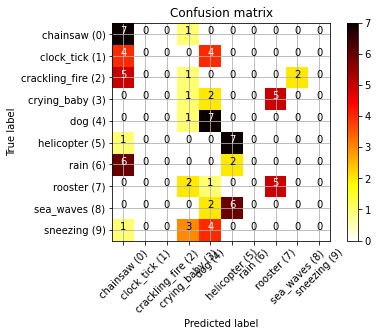

In [50]:
predictions = model.predict(input_test)
# afficage de la matrice de confusions
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(10)))
# afficage de la matrice de confusions dans un autre format
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.hot_r)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(idx_to_classes))
plt.grid(None)
classes_name = zip(idx_to_classes, list(range(len(idx_to_classes))))
classes_name = ['{} ({})'.format(*i) for i in classes_name]
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [51]:
scores = model.evaluate(input_test, target_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3/3 - 0s - loss: 18.3330 - accuracy: 0.3375
accuracy: 33.75%


In [53]:
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.datasets import cifar10
from keras.engine import training
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Activation, Average
from keras.losses import categorical_crossentropy
from keras.models import Model, Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
import glob
import numpy as np
import os

In [54]:
input_shape = input_train[0,:,:,:].shape
model_input = Input(shape=input_shape)

In [55]:
def conv_pool_cnn(model_input: Tensor) -> training.Model:
    
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Conv2D(10, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
    
    model = Model(model_input, x, name='conv_pool_cnn')
    
    return model

In [56]:
conv_pool_cnn_model = conv_pool_cnn(model_input)

In [60]:
def compile_and_train(model: training.Model, num_epochs: int) -> Tuple [History, str]: 
    
    model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['acc']) 
    filepath = 'weights/' + model.name + '.{epoch:02d}-{loss:.2f}.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_weights_only=True,
                                                 save_best_only=True, mode='auto', period=1)
    tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=batch_size)
    history = model.fit(x=input_train, y=target_train, batch_size=batch_size, 
                     epochs=num_epochs, verbose=1, callbacks=[checkpoint, tensor_board], validation_split=0.2)
    return history

In [61]:
conv_pool_cnn_history = compile_and_train(conv_pool_cnn_model, num_epochs)

Epoch 1/10
1/8 [==>...........................] - ETA: 0s - loss: 2.3242 - acc: 0.0625WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
8/8 [==============================] - 4s 444ms/step - loss: 2.3882 - acc: 0.1719 - val_loss: 2.5274 - val_acc: 0.0000e+00
Epoch 2/10
8/8 [==============================] - 4s 471ms/step - loss: 2.1237 - acc: 0.2031 - val_loss: 2.8954 - val_acc: 0.0000e+00
Epoch 3/10
8/8 [==============================] - 4s 467ms/step - loss: 2.0303 - acc: 0.2539 - val_loss: 2.9917 - val_acc: 0.0000e+00
Epoch 4/10
8/8 [==============================] - 4s 466ms/step - loss: 1.9589 - acc: 0.2695 - val_loss: 3.0241 - val_acc: 0.0000e+00
Epoch 5/10
8/8 [==============================] - 4s 469ms/step - loss: 1.8647 - acc: 0.2930 - val_loss: 3.7729

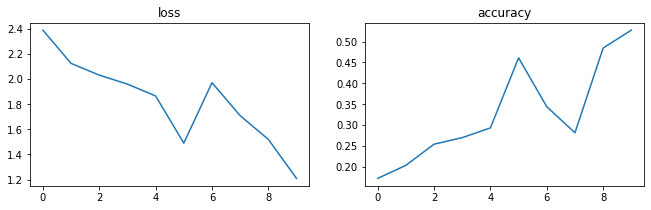

In [64]:
plt.figure(figsize=(11,3))

# affichage de la valeur de la fonction de perte
plt.subplot(1,2,1)
plt.plot(conv_pool_cnn_history.epoch,conv_pool_cnn_history.history['loss'])
plt.title('loss')

# affichage de la précision de notre réseau sur les données d'apprentissage
plt.subplot(1,2,2)
plt.plot(conv_pool_cnn_history.epoch,conv_pool_cnn_history.history['acc'])
plt.title('accuracy');

Confusion matrix (rows: true classes; columns: predicted classes):



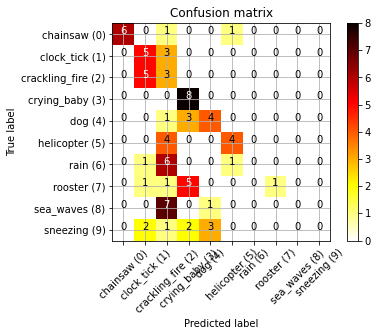

In [62]:
predictions = conv_pool_cnn_model.predict(input_test)
# afficage de la matrice de confusions
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(10)))
# afficage de la matrice de confusions dans un autre format
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.hot_r)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(idx_to_classes))
plt.grid(None)
classes_name = zip(idx_to_classes, list(range(len(idx_to_classes))))
classes_name = ['{} ({})'.format(*i) for i in classes_name]
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [65]:
def evaluate_error(model: training.Model) -> np.float64:
    pred = model.predict(x_test, batch_size = 32)
    pred = np.argmax(pred, axis=1)
    pred = np.expand_dims(pred, axis=1) # make same shape as y_test
    error = np.sum(np.not_equal(pred, y_test)) / y_test.shape[0]   
 
    return error
evaluate_error(conv_pool_cnn_model)

72.0

In [66]:
scores = conv_pool_cnn_model.evaluate(input_test, target_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3/3 - 0s - loss: 3.2531 - acc: 0.3875
accuracy: 38.75%


In [67]:
def all_cnn(model_input: Tensor) -> training.Model:
    
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Conv2D(10, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
        
    model = Model(model_input, x, name='all_cnn')
    model.summary()
    
    return model
all_cnn_model = all_cnn(model_input)
all_cnn_history = compile_and_train(all_cnn_model, num_epochs)

Model: "all_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 216, 1)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 216, 96)      960       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 216, 96)      83040     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 108, 96)       83040     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 108, 192)      166080    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 108, 192)      331968    
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 54, 192)       3319

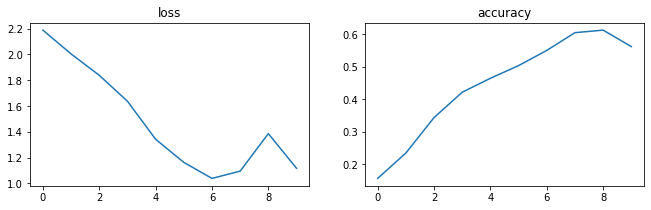

In [69]:
plt.figure(figsize=(11,3))

# affichage de la valeur de la fonction de perte
plt.subplot(1,2,1)
plt.plot(all_cnn_history.epoch,all_cnn_history.history['loss'])
plt.title('loss')

# affichage de la précision de notre réseau sur les données d'apprentissage
plt.subplot(1,2,2)
plt.plot(all_cnn_history.epoch,all_cnn_history.history['acc'])
plt.title('accuracy');

Confusion matrix (rows: true classes; columns: predicted classes):



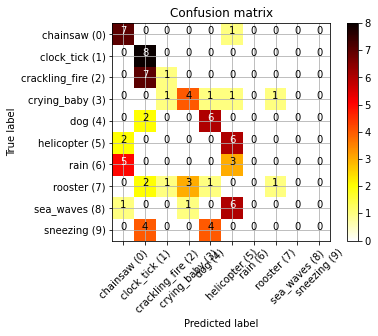

In [71]:
predictions = all_cnn_model.predict(input_test)
# afficage de la matrice de confusions
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(10)))
# afficage de la matrice de confusions dans un autre format
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.hot_r)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(idx_to_classes))
plt.grid(None)
classes_name = zip(idx_to_classes, list(range(len(idx_to_classes))))
classes_name = ['{} ({})'.format(*i) for i in classes_name]
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [70]:
evaluate_error(all_cnn_model)
scores = all_cnn_model.evaluate(input_test, target_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3/3 - 0s - loss: 3.1388 - acc: 0.4125
accuracy: 41.25%
